In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from ndllab.cv import KFold
from ndllab.augment2 import OverSampler
from ndllab.net3 import network

In [ ]:
#--------------------------------------------------------------------------------------------------
#  k-分割交差検証
# トレーニングセットとバリデーションセットをそれぞれk個に等分する。
# そして異なるサブネットを用いて、k回のモデル作成を行う。
# scikit-learnには、k-分割交差検証を行うための関数 sklearn.model_selection.KFold が実装されている。
# 交差検証で用いるトレーニングセットとバリデーションセットの組を作るには、
# sklearn.model_selection.train_test_split を KFold().split() に置き換える。
#--------------------------------------------------------------------------------------------------

In [2]:
# パラメーター
# バッチサイズ
BATCH_SIZE = 32
# 学習回数
NUM_EPOCHS = 5
NUM_STEPS = 1000
# 学習中の出力頻度
OUTPUT_BY_STEPS = 500
# 学習率の初期値
LEARNING_RATE = 1e-4
# ドロップアウト率
DROPOUT_PROB_1 = 0.5
DROPOUT_PROB_2 = 0.5
# 交差検証の分割数
N_FOLDS = 5

In [3]:
# 再現性の確保のために乱数シードを固定
np.random.seed(12345)

# 平仮名データセットのワンホット表現での読み込み
kfold = KFold(one_hot=True, cv=N_FOLDS)

In [4]:
# グラフの定義
g = tf.Graph()
with g.as_default():
    # 再現性の確保のために乱数シードを固定（数値は何でもよい）
    tf.set_random_seed(12345)
    # 入力
    x = tf.placeholder(tf.float32, name='images', shape=(None, 48, 48, 3))
    p_1 = tf.placeholder(tf.float32, name='p_1')
    p_2 = tf.placeholder(tf.float32, name='p_2')
    labels = tf.placeholder(tf.float32, name='labels',
                            shape=(None, kfold.n_classes))
    
    # 出力 (softmax)
    y = network(x, p_1, p_2)

    # 損失関数（交差エントロピー）と最適化処理（Adam）
    loss = -tf.reduce_sum(labels * tf.log(y + 1e-9)) / tf.cast(tf.shape(y)[0], tf.float32)

    # 1エポックごとに学習率を小さくする
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        learning_rate=LEARNING_RATE, decay_rate=0.5, decay_steps=NUM_STEPS, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # 精度検証 (Top-1 accuracy)
    prediction_match = tf.equal(tf.argmax(y, axis=1), tf.argmax(labels, axis=1))
    accuracy = tf.reduce_mean(tf.cast(prediction_match, tf.float32), name='accuracy')



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
def train(sess, dropout_prob, trainset, valset):
    records = list()
    
    step = 0

    # データセット全体を NUM_EPOCHS 回学習する
    for epoch in range(NUM_EPOCHS):
        batch_iter = trainset.next_batch(BATCH_SIZE)

        # イテレータを NUM_STEPS 回呼び出す
        for _ in range(NUM_STEPS):
            batch = next(batch_iter)
            # 正規化
            normalized_batch = batch[0] / 255.0
            # バッチ学習
            optimizer.run(feed_dict={x: normalized_batch,
                                    labels: batch[1], **dropout_prob})

            # コンソールへの出力
            if step % OUTPUT_BY_STEPS == 0:
                train_loss, train_accuracy = sess.run([loss, accuracy],
                                                    feed_dict={x: normalized_batch, labels: batch[1], p_1: 1.0, p_2: 1.0})

                val_images, val_labels = valset.images / 255.0, valset.labels
                val_loss, val_y = sess.run([loss, y],
                                        feed_dict={x: val_images, labels: val_labels, p_1: 1.0, p_2: 1.0})

                y_pred = np.argmax(val_y, axis=1)
                y_true = np.argmax(valset.labels, axis=1)
                val_accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
                val_f1_macro = f1_score(
                    y_true=y_true, y_pred=y_pred, average='macro')
                record = dict()
                record['epoch'] = epoch
                record['step'] = step
                record['train_loss'] = train_loss
                record['train_accuracy'] = train_accuracy
                record['val_loss'] = val_loss
                record['val_accuracy'] = val_accuracy
                record['val_f1_macro'] = val_f1_macro
                records.append(record)
                print(record)

            # ステップ数を更新
            step += 1
    return records

In [ ]:
#--------------------------------------------------------------------------------------------------
# 5-fold交差検証を実行する
# loss、精度、F値を500エポックごとに計算する処理を実装する
# また、loss、精度、F値の計算結果をCSV (5fold_cv.csv) とコンソールの両方に出力する
#--------------------------------------------------------------------------------------------------

In [6]:
# セッション
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    dropout_prob = {p_1: DROPOUT_PROB_1, p_2: DROPOUT_PROB_2}
    train_sampler = OverSampler()

    df = pd.DataFrame()
    for k, (trainset, valset) in enumerate(kfold.next_train_val()):
        # トレーニングデータに対して、オーバーサンプリングを適用する
        resampled_trainset = train_sampler.resample_from_dataset(trainset)
        # トレーニング
        print('Fold {:d}/{:d}'.format(k+1, N_FOLDS))
        local_records = train(sess, dropout_prob, resampled_trainset, valset)
        # トレーニングの結果を記録
        local_df = pd.DataFrame(local_records)
        local_df['fold'] = k
        df = df.append(local_df, ignore_index=True)
    
    path = Path('{:d}fold_cv.csv'.format(N_FOLDS))
    df.to_csv(path, index=False)
    print('write: {}'.format(path))


Fold 1/5
{'epoch': 0, 'step': 0, 'train_loss': 4.288516, 'train_accuracy': 0.09375, 'val_loss': 4.2904167, 'val_accuracy': 0.016953125, 'val_f1_macro': 0.0004567262410272763}
{'epoch': 0, 'step': 500, 'train_loss': 2.2569866, 'train_accuracy': 0.5, 'val_loss': 2.3176742, 'val_accuracy': 0.499921875, 'val_f1_macro': 0.4225479264291372}
{'epoch': 1, 'step': 1000, 'train_loss': 0.96595585, 'train_accuracy': 0.625, 'val_loss': 0.93666387, 'val_accuracy': 0.775078125, 'val_f1_macro': 0.7388584651571345}
{'epoch': 1, 'step': 1500, 'train_loss': 1.3389697, 'train_accuracy': 0.625, 'val_loss': 0.615573, 'val_accuracy': 0.858046875, 'val_f1_macro': 0.815617269540006}
{'epoch': 2, 'step': 2000, 'train_loss': 0.29012957, 'train_accuracy': 0.9375, 'val_loss': 0.46358153, 'val_accuracy': 0.90421875, 'val_f1_macro': 0.8648423390151593}
{'epoch': 2, 'step': 2500, 'train_loss': 0.45994517, 'train_accuracy': 0.90625, 'val_loss': 0.36180466, 'val_accuracy': 0.92046875, 'val_f1_macro': 0.8768954319537893

In [ ]:
#--------------------------------------------------------------------------------------------------
# 交差検証の結果を可視化する
# 具体的には、5-flod交差検証で得られる分割ごとの精度について、
# バリデーションセットに対する平均と95%信頼区間を1エポックごとに計算し、グラフとして出力する
#--------------------------------------------------------------------------------------------------

In [7]:
import scipy.stats
import matplotlib.pyplot as plt

In [8]:
# 交差検証の分割数
N_FOLDS = 5
# 集計対象の列名
AGG_COLUMNS = ['train_loss', 'train_accuracy',
               'val_loss', 'val_accuracy', 'val_f1_macro']

In [9]:
def clien(x, alpha=0.95):
    """
    集計関数
    """
    if len(x) <= 1:
        return 0
    m, e, df = np.mean(x), scipy.stats.sem(x), len(x) - 1
    interval = scipy.stats.t.interval(alpha, df, loc=m, scale=e)
    cilen = np.max(interval) - np.mean(interval)
    return cilen

In [10]:
# 5-fold交差検証の結果を読み込む
df = pd.read_csv('{:d}fold_cv.csv'.format(N_FOLDS)
                 ).loc[:, AGG_COLUMNS + ['step']]

# ステップ数を横軸(x軸)として、結果を集計する
g = df.groupby('step')
x = g.apply(lambda x: x.name)
# 平均を求める
y = g.mean()
# 平均の95%信頼区間を求める
yci = g.agg(lambda x: clien(x, alpha=0.95))
# 信頼区間の上側
y_upper = y + yci
# 信頼区間の下側
y_lower = y - yci

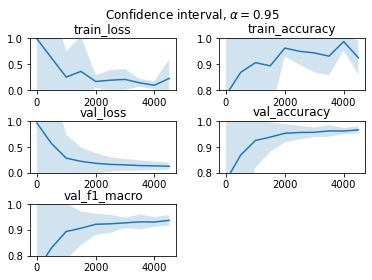

In [11]:
# グラフを描画する
for i, column in enumerate(AGG_COLUMNS):
    # グラフを3x2に分割して表示する
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    # 平均の信頼区間を描画
    plt.fill_between(
        x, y2=y_lower.loc[:, column].values, y1=y_upper.loc[:, column].values, alpha=0.2)
    # 平均を描画
    plt.plot(x, y.loc[:, column])
    # 縦軸の目盛りを調整
    if 'loss' in column:
        plt.ylim([0, 1])
    else:
        plt.ylim([0.8, 1.0])
    # グラフごとにタイトルを設定
    plt.title(column)
# グラフ全体のタイトルを設定
plt.suptitle(r'Confidence interval, $\alpha=0.95$', y=0.99)
plt.show()